In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import copy
from datetime import timedelta

%matplotlib inline

In [2]:
outdir='data/'
dsets = ['_moc_rho2_online_lores.nc', '_moc_rho2_online_mean_lores_reprojected.nc','_sigma2_jmd95_zmean.nc']

ddict = {mod:{} for mod in ['CM4','ESM4']}

for mod in ddict:
    ddict_exp = {exp:{} for exp in ['control','stress','antwater','antwaterstress']}
    for exp in ddict_exp:
        if exp == 'control':
            
            for dset,var in zip(dsets,['psi','psiz','sig2']):
                files = glob.glob(outdir+'%s_%s_global_*'%(mod,exp)+dset)
                if len(files)>1:
                    print('WARNING: More than one file for %s. Please specify.'%dset)
                    print('Loading '+files[0])
                elif len(files)==0:
                    print('ERROR: No file available for %s'%dset,mod+'-'+exp)
                    ddict_exp[exp][var] = []
                    continue
                    
                if var=='sig2':
                    ddict_exp[exp][var] = xr.open_dataset(files[0]).sigma2
                else:
                    ddict_exp[exp][var] = xr.open_dataset(files[0]).psi
        else:
            ddict_mem = {mem:{} for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201'])}
            for mem in ddict_mem:
                for dset,var in zip(dsets,['psi','psiz','sig2']):
                    
                    files = glob.glob(outdir+'%s_%s_%s_global_*'%(mod,exp,mem)+dset)
                        
                    if len(files)>1:
                        print('WARNING: More than one file for %s. Please specify.'%dset)
                        print('Loading '+files[0])
                    elif len(files)==0:
                        print('ERROR: No file available for %s'%dset,mod+'-'+exp+'-'+mem)
                        ddict_mem[mem][var] = []
                        continue
                        
                    if var=='sig2':
                        ddict_mem[mem][var] = xr.open_dataset(files[0]).sigma2
                    else:
                        ddict_mem[mem][var] = xr.open_dataset(files[0]).psi
                    
            ddict_exp[exp] = ddict_mem
                    
    ddict[mod] = ddict_exp

In [3]:
contours = np.concatenate([np.arange(-25,0,5),np.arange(5,30,5)])

In [4]:
texp = ['0051','0070']

## Mean

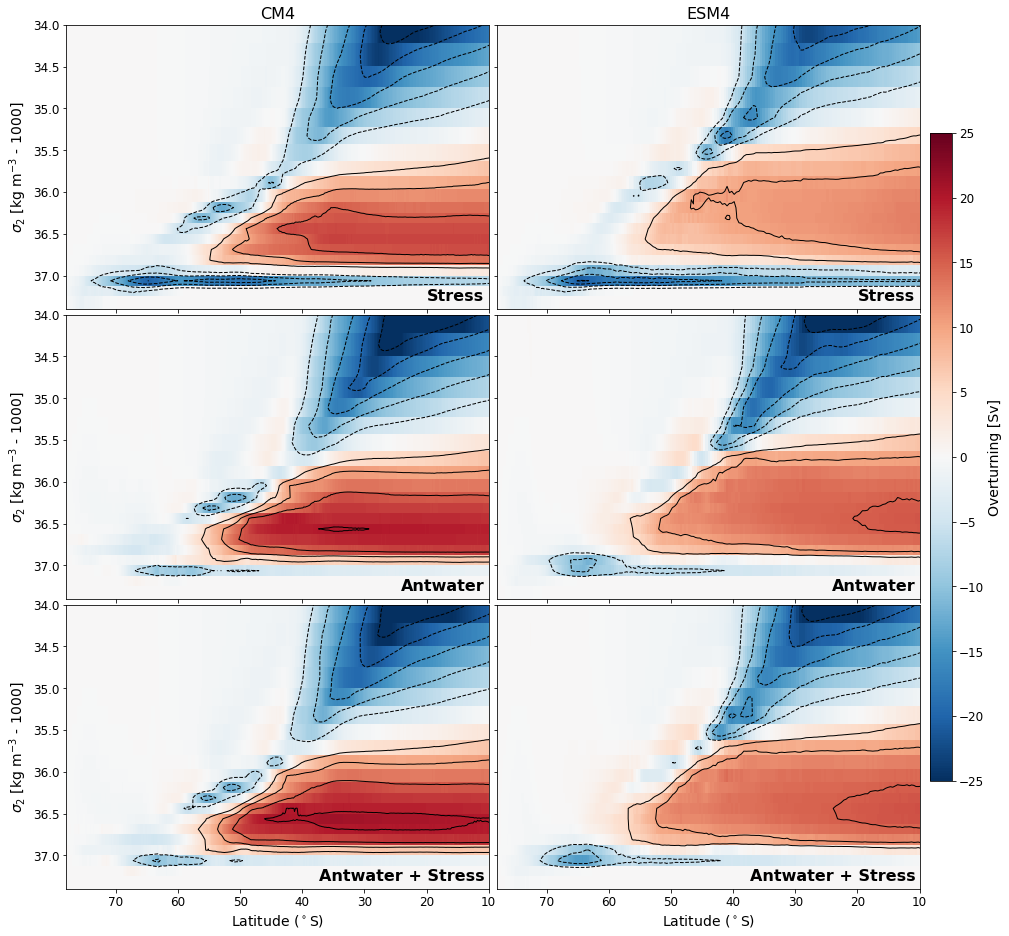

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.02, wspace=0.02)

for i, mod in enumerate(ddict):
    
    tctr = ['0281', '0380'] if mod=='CM4' else ['0121', '0220']
    smoc_ctrl = ddict[mod]['control']['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
    smoc_ctrl_mean = smoc_ctrl.sel(time=slice(tctr[0],tctr[1])).mean('time')
    smoc_ctrl_mean['sigma2'] = smoc_ctrl_mean.rho2_i-1000
    smoc_ctrl_mean = smoc_ctrl_mean.swap_dims({'rho2_i':'sigma2'})
          
    for j, exp in enumerate(list(ddict[mod].keys())[1:]):
        smoc = []
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            smoc_m = ddict[mod][exp][mem]['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
            
            if mem == '101':
                smoc_m['time'] = smoc_m.time - timedelta(days=365*(int(mem)-1))
            
            smoc_m = smoc_m.sel(time=slice(texp[0],texp[1])).reset_coords(drop=True)
            smoc_m['mem'] = int(mem)
            smoc.append(smoc_m)
            
        smoc_mean = xr.concat(smoc, dim='mem').mean('mem').mean('time')
        smoc_mean['sigma2'] = smoc_mean.rho2_i-1000
        smoc_mean = smoc_mean.swap_dims({'rho2_i':'sigma2'})
        
        p = smoc_mean.plot(ax=axs[j,i], yincrease=False,vmin=-25,vmax=25,cmap='RdBu_r', 
                       add_colorbar=False, add_labels=False)
        #smoc_ctrl_mean.plot.contour(ax=axs[j,i], yincrease=False, levels=contours, colors='k', 
        #                       linewidths=1, add_labels=False)
        smoc_mean.plot.contour(ax=axs[j,i], yincrease=False, levels=contours, colors='k', 
                               linewidths=1, add_labels=False)
        axs[j,i].set_xlim([-78,-10])
        axs[j,i].set_ylim([37.4,34.0])
        axs[j,i].set_xticks(np.arange(-70,0,10))
        axs[j,i].set_xticklabels(np.arange(70,0,-10))
        axs[j,i].set_yticks(np.arange(37.0,33.5,-0.5))
        axs[j,i].set_xlabel('Latitude ($^\circ$S)',fontsize=14)
        axs[j,i].tick_params(axis='both', which='both', labelsize=12)
    
        axs[j,i].text(0.99, 0.02, exp[:8].capitalize()+' + '+exp[8:].capitalize() \
                      if exp=='antwaterstress' else exp.capitalize(), ha='right', va='bottom', fontsize=16, 
                      fontweight='bold',transform=axs[j,i].transAxes)
        
        if mod != 'CM4':
            axs[j,i].set_yticklabels([])
        else:
            axs[j,i].set_ylabel('$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
            
        if exp == 'antwaterstress':
            axs[j,i].set_xlabel('Latitude ($^\circ$S)',fontsize=14)
        else:
            axs[j,i].set_xticklabels([])
        
axs[0,0].set_title('CM4',fontsize=16)
axs[0,1].set_title('ESM4',fontsize=16)

cax = fig.add_axes([0.9, 0.2, 0.02, 0.60])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-25,30,5), orientation='vertical', shrink=0.9, pad=0.02)
cb.set_label(r'Overturning [Sv]', fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.show()

### Check maximum/minimum overturning

Minimum: -11.7 Sv at 63.3 S and 36.9 kg/m^3 density
Maximum: 14.6 Sv at 30.0 S and 36.3 kg/m^3 density


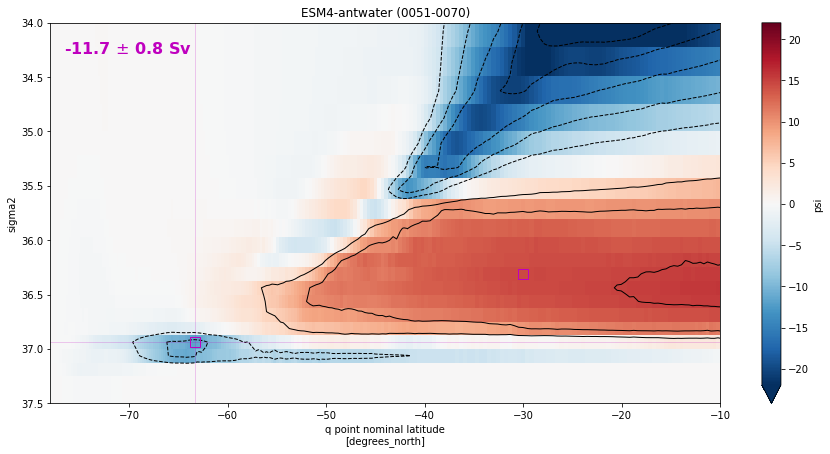

In [6]:
mod = 'ESM4' # CM4, ESM4
exp = 'antwater' # control, stress, antwater, antwaterstress

emean = True # Plot ensemble mean (True) or individual member (False)

# If emean = False, select ensemble member
mem = '332' # 251, 290, 332 (CM4), 101, 151, 201 (ESM4)


tctr = ['0281', '0380'] if mod=='CM4' else ['0121', '0220']
texp = ['0051','0070']

if exp=='control':
    psi = ddict[mod][exp]['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0)).sel(time=slice(tctr[0],tctr[1]))
else:
    if emean:
        psis = []
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            
            psi_m = ddict[mod][exp][mem]['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
            if mem == '101':
                psi_m['time'] = psi_m.time - timedelta(days=365*(int(mem)-1))
                
            psi_m = psi_m.sel(time=slice(texp[0],texp[1])).reset_coords(drop=True)
            psi_m['mem'] = int(mem)
            psis.append(psi_m)
            psi = xr.concat(psis, dim='mem').mean('mem')
    
    else:
        if mem == '101':
            psi = ddict[mod][exp][mem]['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
            psi['time'] = psi.time - timedelta(days=365*(int(mem)-1))
        else:
            psi = ddict[mod][exp][mem]['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
            
        psi = psi.sel(time=slice(texp[0],texp[1]))
        

if emean & (exp!='control'):
    smoc = xr.concat(psis, dim='mem').mean('time')
    smoc['sigma2'] = smoc.rho2_i-1000
    smoc = smoc.swap_dims({'rho2_i':'sigma2'})
    smoc_lower = smoc.sel(sigma2=slice(36.5,None),yq=slice(None,-55))
    sd = smoc_lower.min(dim=['sigma2', 'yq']).std('mem').values
else:
    smoc = psi
    smoc['sigma2'] = smoc.rho2_i-1000
    smoc = smoc.swap_dims({'rho2_i':'sigma2'})
    smoc_lower = smoc.sel(sigma2=slice(36.5,None),yq=slice(None,-55))
    sd = smoc_lower.min(dim=['sigma2', 'yq']).groupby('time.year').mean('time').std('year').values
    
    
smoc_mean = psi.mean('time')
smoc_mean['sigma2'] = smoc_mean.rho2_i-1000
smoc_mean = smoc_mean.swap_dims({'rho2_i':'sigma2'})

# Find the location of the minimum (lower limb overturning)
smoc_lower_mean = smoc_mean.sel(sigma2=slice(36.5,None),yq=slice(None,-55))
y_min_idx = smoc_lower_mean.argmin(dim=['sigma2', 'yq'])['yq']
rho2_min_idx = smoc_lower_mean.argmin(dim=['sigma2', 'yq'])['sigma2']

# Find the location of the maximum (upper limb overturning)
smoc_upper_mean = smoc_mean.sel(sigma2=slice(35,None),yq=slice(None,-30))
y_max_idx = smoc_upper_mean.argmax(dim=['sigma2', 'yq'])['yq']
rho2_max_idx = smoc_upper_mean.argmax(dim=['sigma2', 'yq'])['sigma2']

print('Minimum:',
      np.round(smoc_lower_mean.isel(sigma2=rho2_min_idx,yq=y_min_idx).values,1),'Sv at',
      -np.round(smoc_lower_mean.yq[y_min_idx].values,1),'S and',
      np.round(smoc_lower_mean.sigma2[rho2_min_idx].values,1),'kg/m^3 density')
print('Maximum:',
      np.round(smoc_upper_mean.isel(sigma2=rho2_max_idx,yq=y_max_idx).values,1),'Sv at',
      -np.round(smoc_upper_mean.yq[y_max_idx].values,1),'S and',
      np.round(smoc_upper_mean.sigma2[rho2_max_idx].values,1),'kg/m^3 density')


fig, ax = plt.subplots(figsize=(15,7))
smoc_mean.plot(ax=ax, yincrease=False,vmin=-22,vmax=22,cmap='RdBu_r',
               cbar_kwargs={'ticks': np.arange(-25,30,5)})
smoc_mean.plot.contour(ax=ax, yincrease=False, levels=contours, colors='k', linewidths=1)
ax.plot(smoc_lower_mean.yq[y_min_idx],smoc_lower_mean.sigma2[rho2_min_idx],
        marker='s',c='m',ms=10,mew=1,mfc='none')
ax.plot(smoc_upper_mean.yq[y_max_idx],smoc_upper_mean.sigma2[rho2_max_idx],
        marker='s',c='m',ms=10,mew=1,mfc='none')
ax.set_xlim((-78,-10))
ax.set_ylim((37.5,34))
ax.set_title('%s-%s'%(mod,exp)+ ' (%s-%s)'%(str(psi.time.dt.year[0].values).rjust(4, '0'),
                           str(psi.time.dt.year[-1].values).rjust(4, '0'))\
             if ((exp=='control')|emean) else '%s-%s-%s'%(mod,exp,mem) \
                 + ' (%s-%s)'%(str(psi.time.dt.year[0].values).rjust(4, '0'),
                               str(psi.time.dt.year[-1].values).rjust(4, '0')))

ax.axvline(x=smoc_lower_mean.yq[y_min_idx], ymin=0, ymax=1, linewidth=1.0, color = 'm',alpha=0.2)
ax.axhline(y=smoc_lower_mean.sigma2[rho2_min_idx], xmin=0, xmax=1, linewidth=1.0, color = 'm',alpha=0.2)
ax.text(0.02, 0.91, '%1.1f $\pm$ %1.1f Sv'%(np.round(smoc_lower_mean.isel(sigma2=rho2_min_idx,
                                                                          yq=y_min_idx).values,1),sd),
        horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes, 
        fontsize=16, fontweight='bold',color='m')


plt.show()

## Anomaly

In [7]:
# define the colormap
#cmap = plt.cm.RdBu_r
cmap = copy.copy(plt.cm.PiYG) #RdBu_r

# extract all colors from cmap
cmaplist = [cmap(i) for i in range(cmap.N)]

# force the center colors to be white
for x in range(round(cmap.N/2-cmap.N/20),round(cmap.N/2+cmap.N/20)):
    cmaplist[x] = (1,1,1,1.0)
    
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

cmap.set_over('darkgreen') # maroon
cmap.set_under('grey') # midnightblue

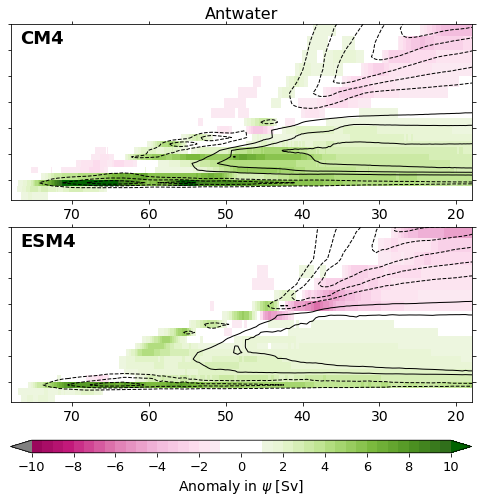

In [8]:
exp = 'antwater'

fig, axs = plt.subplots(2, 1, figsize=(8,7))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, hspace=0.15)

for i, mod in enumerate(ddict):
    
    smoc_ctrl = ddict[mod]['control']['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,10))
    if mod=='CM4':
        smoc_ctrl_mean = smoc_ctrl.sel(time=slice('0281','0380')).mean('time')
    elif mod=='ESM4':
        smoc_ctrl_mean = smoc_ctrl.sel(time=slice('0121','0220')).mean('time')
        
    smoc_ctrl_mean['sigma2'] = smoc_ctrl_mean.rho2_i-1000
    smoc_ctrl_mean = smoc_ctrl_mean.swap_dims({'rho2_i':'sigma2'})
    
    smoc = []
    for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
        smoc_m = ddict[mod][exp][mem]['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
        
        if mem == '101':
            smoc_m['time'] = smoc_m.time - timedelta(days=365*(int(mem)-1))
            
        smoc_m = smoc_m.sel(time=slice(texp[0],texp[1])).reset_coords(drop=True)
        smoc_m['mem'] = int(mem)
        smoc.append(smoc_m)
        
    smoc_mean = xr.concat(smoc, dim='mem').mean('mem').mean('time')
    smoc_mean['sigma2'] = smoc_mean.rho2_i-1000
    smoc_mean = smoc_mean.swap_dims({'rho2_i':'sigma2'})
    
    smoc_anom = smoc_mean - smoc_ctrl_mean
    
    p = smoc_anom.plot(ax=axs[i], yincrease=False,vmin=-10,vmax=10,cmap=cmap, levels=41, extend='both',
                       add_colorbar=False, add_labels=False)
    smoc_ctrl_mean.plot.contour(ax=axs[i], yincrease=False, levels=contours, colors='k', linewidths=1,
                                add_labels=False)

    axs[i].set_xlim([-78,-18])
    axs[i].set_ylim([37.4,34.0])
    axs[i].set_xticks(np.arange(-70,-10,10))
    axs[i].set_xticklabels(np.arange(70,10,-10))
    axs[i].set_yticks(np.arange(37.0,33.5,-0.5))
    axs[i].set_yticklabels([])
    axs[i].tick_params(axis='both', which='both', labelsize=14,top=True,right=True)

axs[0].set_title('Antwater',fontsize=16)
#axs[1].set_xlabel('Latitude ($^\circ$S)',fontsize=14)
axs[0].text(0.02, 0.97, 'CM4', ha='left', va='top', fontsize=18, fontweight='bold',
                transform=axs[0].transAxes)
axs[1].text(0.02, 0.97, 'ESM4', ha='left', va='top', fontsize=18, fontweight='bold',
                transform=axs[1].transAxes)

cax = fig.add_axes([0.1, 0.05, 0.8, 0.025])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-10,12,2), orientation='horizontal', shrink=0.9, pad=0.02)
cb.set_label(r'Anomaly in $\psi$ [Sv]', fontsize=14)
cb.ax.tick_params(labelsize=13)

plt.show()

### Figure 4

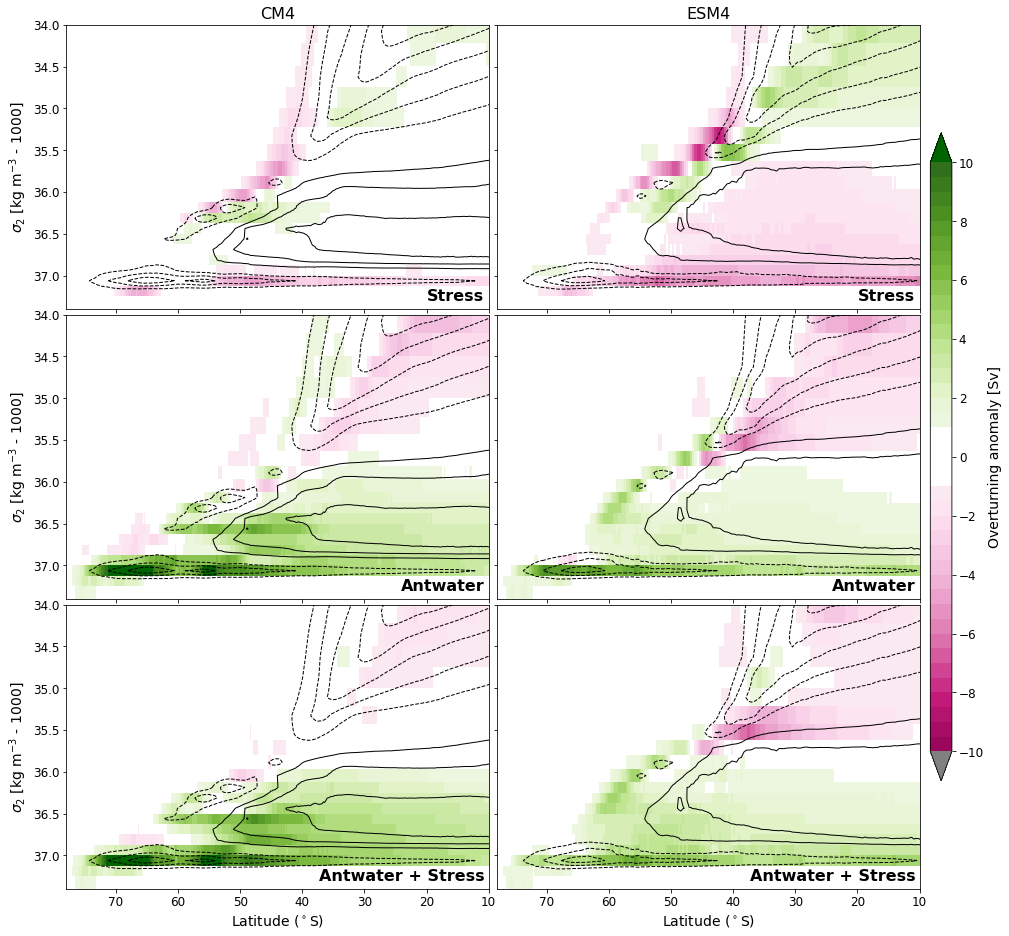

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.02, wspace=0.02)

for i, mod in enumerate(ddict):
    
    tctr = ['0281', '0380'] if mod=='CM4' else ['0121', '0220']
    smoc_ctrl = ddict[mod]['control']['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
    smoc_ctrl_mean = smoc_ctrl.sel(time=slice(tctr[0],tctr[1])).mean('time')
    smoc_ctrl_mean['sigma2'] = smoc_ctrl_mean.rho2_i-1000
    smoc_ctrl_mean = smoc_ctrl_mean.swap_dims({'rho2_i':'sigma2'})
          
    for j, exp in enumerate(list(ddict[mod].keys())[1:]):
        smoc = []
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            smoc_m = ddict[mod][exp][mem]['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
            
            if mem == '101':
                smoc_m['time'] = smoc_m.time - timedelta(days=365*(int(mem)-1))
            
            smoc_m = smoc_m.sel(time=slice(texp[0],texp[1])).reset_coords(drop=True)
            smoc_m['mem'] = int(mem)
            smoc.append(smoc_m)
            
        smoc_mean = xr.concat(smoc, dim='mem').mean('mem').mean('time')
        smoc_mean['sigma2'] = smoc_mean.rho2_i-1000
        smoc_mean = smoc_mean.swap_dims({'rho2_i':'sigma2'})
        
        smoc_anom = smoc_mean - smoc_ctrl_mean
        
        p = smoc_anom.plot(ax=axs[j,i], yincrease=False,vmin=-10,vmax=10,cmap=cmap, levels=41, extend='both',
                           add_colorbar=False, add_labels=False)
        smoc_ctrl_mean.plot.contour(ax=axs[j,i], yincrease=False, levels=contours, colors='k', linewidths=1,
                                    add_labels=False)
        axs[j,i].set_xlim([-78,-10])
        axs[j,i].set_ylim([37.4,34.0])
        axs[j,i].set_xticks(np.arange(-70,0,10))
        axs[j,i].set_xticklabels(np.arange(70,0,-10))
        axs[j,i].set_yticks(np.arange(37.0,33.5,-0.5))
        axs[j,i].set_xlabel('Latitude ($^\circ$S)',fontsize=14)
        axs[j,i].tick_params(axis='both', which='both', labelsize=12)
    
        axs[j,i].text(0.99, 0.02, exp[:8].capitalize()+' + '+exp[8:].capitalize() \
                      if exp=='antwaterstress' else exp.capitalize(), ha='right', va='bottom', fontsize=16, 
                      fontweight='bold',transform=axs[j,i].transAxes)
        
        if mod != 'CM4':
            axs[j,i].set_yticklabels([])
        else:
            axs[j,i].set_ylabel('$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
            
        if exp == 'antwaterstress':
            axs[j,i].set_xlabel('Latitude ($^\circ$S)',fontsize=14)
        else:
            axs[j,i].set_xticklabels([])
        
axs[0,0].set_title('CM4',fontsize=16)
axs[0,1].set_title('ESM4',fontsize=16)

cax = fig.add_axes([0.9, 0.2, 0.02, 0.60])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-10,12,2), orientation='vertical', shrink=0.9, pad=0.02)
cb.set_label(r'Overturning anomaly [Sv]', fontsize=14)
cb.ax.tick_params(labelsize=12)

plt.savefig('smoc_faf_anom.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

**Figure 4**: Anomaly in isopycnal overturning ($\Psi$) in CM4 (left) and ESM4 (right) in Stress (top row), Antwater (middle row) and AntwaterStress (bottom row). Anomalies are calculated from a 20-year mean (year 51-70) of each experiment minus the 100-year mean of the corresponding Control. The anomalies are given by the color shading, while the contours denote $\Psi$ in the corresponding control run (100-yr mean) with intervals of 5 Sv.